In [37]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import logging

import mlflow

### Dataset and train test split

In [2]:
df = pd.read_csv('../../data/external/casas.csv')

In [3]:
df.head()

,tamanho,ano,garagem,preco
0,159.0,2003,2,208500
1,117.0,1976,2,181500
2,166.0,2001,2,223500
3,160.0,1915,3,140000
4,204.0,2000,3,250000


### Preprocessing

In [8]:
def multicolinearity_analysis(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def outliers_analysis(dataframe):
    z_scores = stats.zscore(dataframe.select_dtypes(include=[np.number]))
    outliers = (abs(z_scores) > 3).sum()
    return outliers

In [9]:
multicolin = multicolinearity_analysis(df)
outliers = outliers_analysis(df)

In [10]:
multicolin

,feature,VIF
0,tamanho,18.474565
1,ano,11.063656
2,garagem,11.294744
3,preco,16.441987


In [11]:
outliers

tamanho    16
ano         6
garagem     0
preco      22
dtype: int64

<Axes: ylabel='Frequency'>

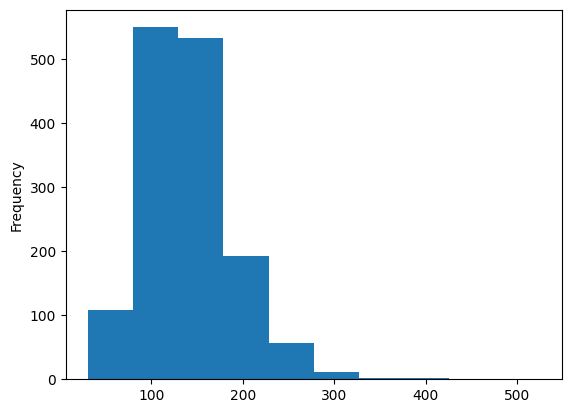

In [12]:
df['tamanho'].plot(kind='hist')

In [17]:
df['tamanho_log'] = np.log1p(df['tamanho'])

<Axes: ylabel='Frequency'>

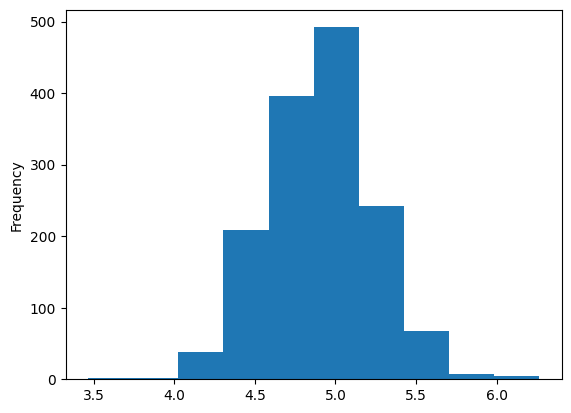

In [19]:
df['tamanho_log'].plot(kind='hist')

<Axes: ylabel='Frequency'>

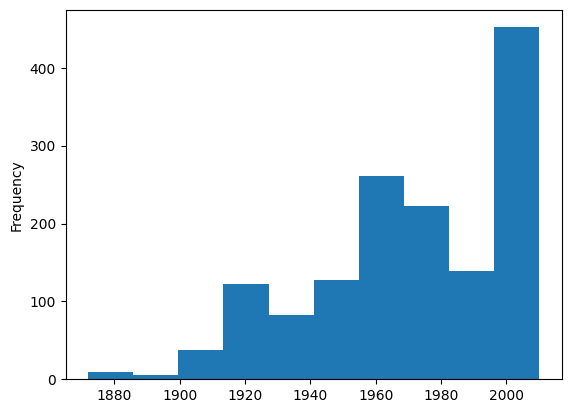

In [29]:
df['ano'].plot(kind='hist')

In [30]:
df['ano_log'] = np.log1p(df['ano'])

<Axes: ylabel='Frequency'>

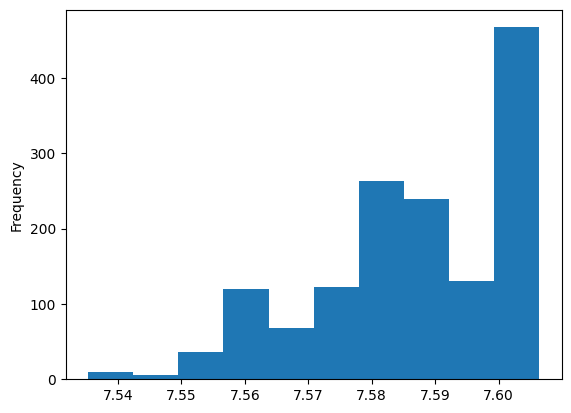

In [31]:
df['ano_log'].plot(kind='hist')

### Experiments

In [32]:
X = df.drop(columns=['preco', 'tamanho', 'ano'])
y = df['preco'].copy()

In [33]:
print('Shape de X: {}'.format(X.shape))
print('Shape de y: {}'.format(y.shape))

Shape de X: (1460, 3)
Shape de y: (1460,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [69]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('optimize-models')

2024/11/15 23:09:28 INFO mlflow.tracking.fluent: Experiment with name 'optimize-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/385544827691376399', creation_time=1731722968544, experiment_id='385544827691376399', last_update_time=1731722968544, lifecycle_stage='active', name='optimize-models', tags={}>

In [70]:
def bayesian_search_cv(model, param_grid):
    with mlflow.start_run(run_name=f'BayesSearchCV{model.__class__.__name__}'):
        mlflow.sklearn.autolog()
        bayesian_search = BayesSearchCV(model, 
                                         param_grid, 
                                         cv=5)
        bayesian_search.fit(X_train, y_train)
        
        best_model = bayesian_search.best_estimator_
        predictions = best_model.predict(X_test)
        rmse = root_mean_squared_error(predictions, y_test)
        r2 = r2_score(predictions, y_test)

        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('R2 Score', r2)
        logging.info(f'Melhores parâmetros: {bayesian_search.best_params_}')
        logging.info(f'Precisão (acurácia): {rmse}')

In [71]:
lr_params = {'fit_intercept': [True, False],
             'copy_X': [True, False],
             'positive': [True, False]}

dt_params = {'splitter':['best', 'random'],
             'max_depth':[1, 2, 5, 10, 20],
             'min_samples_split':[2, 4, 6, 8, 10],
             'min_samples_leaf':[1, 2, 5, 10, 20],
             'min_weight_fraction_leaf':[0.01, 0.1, 0.5],
             'max_features':[1, 2, 3],
             'random_state':[10, 20, 42, 1000],
             'min_impurity_decrease':[0.01, 0.1, 0.5],
             'ccp_alpha':[0.01, 0.1, 0.5]}

rf_params = {'n_estimators': [100, 200, 300, 400],
             'max_depth': [1, 2, 5, 10, 20],
             'min_samples_split': [2, 4, 6, 8, 10],
             'min_samples_leaf': [1, 2, 5, 10, 20],
             'min_weight_fraction_leaf': [0.01, 0.1, 0.5],
             'max_features': [1, 2, 3],
             'random_state': [10, 20, 42, 1000],
             'min_impurity_decrease': [0.01, 0.1, 0.5],
             'ccp_alpha': [0.01, 0.1, 0.5]}

ab_params = {'n_estimators': [50, 100, 200, 400],
             'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
             'loss': ['linear', 'square', 'exponential'],
             'random_state': [10, 20, 42, 1000]}

gb_params = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
             'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
             'n_estimators': [100, 200, 300, 400],
             'subsample': [0.1, 0.2, 0.3, 0.5, 0.7, 1.0],
             'criterion': ['friedman_mse', 'squared_error'],
             'min_samples_split': [2, 4, 6, 8, 10],
             'min_samples_leaf': [1, 2, 5, 10, 20],
             'min_weight_fraction_leaf': [0.01, 0.1, 0.5],
             'max_depth': [1, 2, 5, 10, 20],
             'min_impurity_decrease': [0.01, 0.1, 0.5],
             'random_state': [10, 20, 42, 1000]}

In [72]:
lr_model = bayesian_search_cv(LinearRegression(), lr_params)

2024/11/15 23:09:28 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


2024/11/15 23:09:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/juanvieira/local/houses/env/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/15 23:09:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/juanvieira/local/houses/env/l

KeyboardInterrupt: 

In [73]:
dt_model = bayesian_search_cv(DecisionTreeRegressor(), dt_params)

2024/11/15 23:12:50 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/15 23:12:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/juanvieira/local/houses/env/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these 

KeyboardInterrupt: 

In [ ]:
rf_model = bayesian_search_cv(RandomForestRegressor(), rf_params)

2024/11/15 23:09:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run BayesSearchCVRandomForestRegressor at: http://127.0.0.1:5000/#/experiments/442341022936690658/runs/c418eadff36644b7bfb0ccecf9489210.
2024/11/15 23:09:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442341022936690658.


KeyboardInterrupt: 

In [ ]:
ab_model = bayesian_search_cv(AdaBoostRegressor(), ab_params)

/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/cor

In [ ]:
gb_model = bayesian_search_cv(GradientBoostingRegressor(), gb_params)

/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/juanvieira/local/houses/env/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print(lr_model)

None


In [ ]:
print(dt_model)

None


In [ ]:
print(rf_model)

None


In [ ]:
print(ab_model)

None


In [ ]:
print(gb_model)

None
